In [1]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, LeakyReLU, Add, Dense, Flatten, UpSampling2D, PReLU
import itertools
from IPython import display
import datetime
import time

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
       gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
    except RuntimeError as e:
        print(e)
        

In [4]:
PATH = "../pytorch/celeba_data/img_align_celeba/img_align_celeba/*"
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 8
EPOCH =  1000
IMAGE_LEN = len(os.listdir("../pytorch/celeba_data/img_align_celeba/img_align_celeba/"))

In [18]:
def data_loader(PATH):
    images_list = tf.data.Dataset.list_files(PATH, shuffle = True)
    images_dateset = images_list.map(image_processing, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)
    return images_dateset

def image_processing(file_path):
    img = tf.io.read_file(file_path)
    hr_img, lr_img = decode_img(img)
    return hr_img, lr_img

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
    img = (img-0.5)/0.5
    hr_img =  tf.image.resize(img, [256, 256])
    lr_img = tf.image.resize(img, [64, 64])
    return hr_img, lr_img

In [22]:
train_dataset = data_loader(PATH)

In [23]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
gen_log_dir = 'logs/gen_log/gradient_tape/' + current_time + '/gen'
disc_log_dir = 'logs/disc_log/gradient_tape/' + current_time + '/disc'
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)

In [24]:
def residual_block(x):
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"
    
    res = Conv2D(filters= filters[0], kernel_size = kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)
    
    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)
    res = Add()([res,x])
    
    return res
    

def generator_model():
    input_shape = (64,64,3)
    residual_blocks = 16
    momentum = 0.8
    input_layer = tf.keras.Input(shape=input_shape)
    gen1 = tf.keras.layers.Conv2D(filters=64, kernel_size = 9, strides=1, padding='same', activation='relu')(input_layer)
    res =residual_block(gen1)
    for i in range(residual_blocks-1):
        res = residual_block(res)
    gen2 = Conv2D(filters = 64, kernel_size = 3, strides=1 , padding = "same")(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2) 
    gen3 = Add()([gen2, gen1])
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters= 256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    return tf.keras.Model(inputs = [input_layer], outputs= [output], name = "generator")

def discriminator_model():
    leakyrelu_alpha=0.2
    momentum = 0.8
    input_shape = (256,256,3)
    input_layer = tf.keras.Input(shape=input_shape)
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)
    dis2 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)
    dis4 = Conv2D(filters = 128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis5 = Conv2D(filters=256,kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)
    dis6 = Conv2D(filters = 256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)
    dis7 = Conv2D(filters=512,kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)
    dis8 = Conv2D(filters=512,kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    dis9 = Dense(1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    output = Dense(1, activation='sigmoid')(dis9)
    return tf.keras.Model(inputs = [input_layer], outputs = [output], name = "discriminator")

def vgg_model():
    input_shape = (256,256,3)
    vgg = VGG19(include_top = False, input_shape = input_shape, weights = "imagenet")
    vgg.outputs = [vgg.layers[9].output]
    input_layer =tf.keras.Input(shape = input_shape)
    features = vgg(input_layer)
    return tf.keras.Model(inputs = [input_layer], outputs = [features])

In [51]:
seed = next(iter(train_dataset.take(1)))[:3]
seed = (seed[0][:5], seed[1][:3])

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

In [32]:
generator = generator_model()
discriminator = discriminator_model()
vgg = vgg_model()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


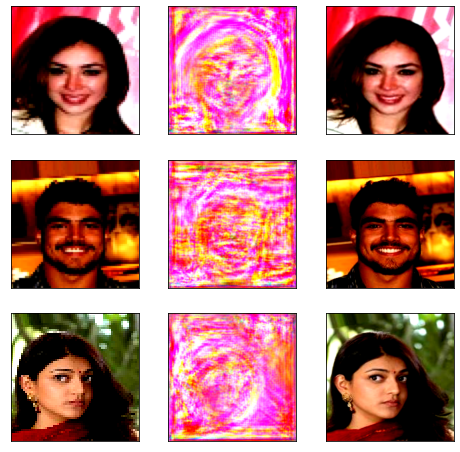

In [43]:
def show_images(seed):
    row_num = 3
    col_num = 3
    fig, ax = plt.subplots(row_num, col_num, figsize = (8,8))
    for i, j in itertools.product(range(row_num), range(col_num)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        
    gen_images = generator(seed[1])
    
    for k in range(row_num*col_num):
        i = k//col_num
        j = k%col_num
        ax[i,j].cla()
        if k%3 == 0:
            img =  seed[1][k//3]
        elif k%3 == 1:
            img = gen_images[k//3,:]
        else:
             img = seed[0][k//3]
        ax[i,j].imshow(img+0.5)
        
show_images(seed)

In [44]:
mse = tf.keras.losses.MeanSquaredError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

def g_loss(fake_features, fake_output, real_features):
    vgg_loss = mse(fake_features, real_features)
    gen_loss = cross_entropy(fake_output, tf.ones_like(fake_output))
    return vgg_loss + 0.001 * gen_loss
    
def d_loss(fake_image, real_image):
    fake_loss = mse(fake_image, tf.zeros_like(fake_image))
    real_loss = mse(real_image, tf.ones_like(real_image))
    return 0.5*(fake_loss + real_loss)

In [45]:
@tf.function
def train_step(hr_images, lr_images):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_hr_images = generator(lr_images, training =True)

        fake_features = vgg(fake_hr_images, training =False)
        real_features = vgg(hr_images, training =False)
        
        fake_output = discriminator(fake_hr_images, training =True)
        real_output = discriminator(hr_images, training =True)
        
        gen_loss = g_loss(fake_features, fake_output, real_features)
        disc_loss = d_loss(fake_output, real_output)
        
    gen_gradient = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_gradient, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [46]:
def train(image_batch, EPOCH):
    for epoch in range(EPOCH):
        start = time.time()
        gen_loss = 0
        disc_loss = 0
        
        for hr_img, lr_img in image_batch:
            loss = train_step(hr_img, lr_img)
            gen_loss+= loss[0].numpy()/IMAGE_LEN
            disc_loss+= loss[1].numpy()/IMAGE_LEN
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("EPOCH : {}, G_loss: {%.4f} , D_loss: {%.4f} ".format(epoch + 1, gen_loss, disc_loss))
        display.clear_output(wait =True)
        show_images(seed)
        
        with gen_summary_writer.as_default():
                tf.summary.scalar('loss', gen_loss, step=epoch+1)
                
        with disc_summary_writer.as_default():
                tf.summary.scalar('loss', disc_loss, step=epoch+1)

In [47]:
%%time
train(train_dataset, EPOCH)

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


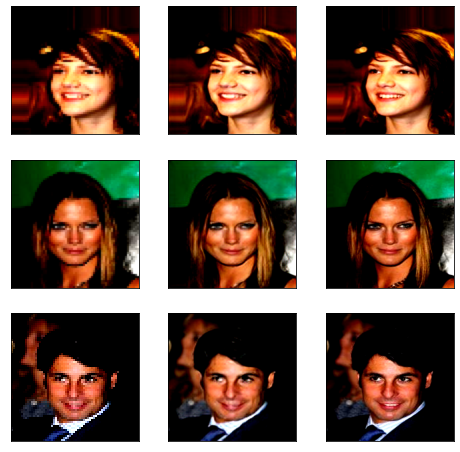

In [52]:
show_images(seed)